In [17]:
import os
import h5py
import numpy as np

import matplotlib.pyplot as plt
%matplotlib notebook

# Retrieving the data

In [54]:
hdf5_file = "data/fitting_y2023_m10_d25_h12_mn55.h5"
assert os.path.exists(hdf5_file)

In [56]:
f = h5py.File(hdf5_file, 'r')
entry = f['entry']

strain_mapping = {}
for _key in entry['strain mapping'].keys():
    strain_mapping[_key] = entry['strain mapping'][_key]['val'][()]

list_row = []
list_column = []
bin = {}
for _key in entry['strain mapping'].keys():
    key_entry = entry['strain mapping'][_key]
    _key_dict = {'x0': key_entry['bin coordinates']['x0'][()],
                 'x1': key_entry['bin coordinates']['x1'][()],
                 'y0': key_entry['bin coordinates']['y0'][()],
                 'y1': key_entry['bin coordinates']['y1'][()],
                 'row_index': entry['fitting']['kropff'][_key]['fitted']['row_index'][()],
                 'column_index': entry['fitting']['kropff'][_key]['fitted']['column_index'][()],
                 }
    list_row.append(entry['fitting']['kropff'][_key]['fitted']['row_index'][()])
    list_column.append(entry['fitting']['kropff'][_key]['fitted']['column_index'][()])
    bin[_key] = _key_dict
    
integrated_image = entry['integrated normalized radiographs']['2D array'][:]
bin_size = entry['metadata']['bin_size'][()]    
    
set_list_row = set(list(list_row))
set_list_column = set(list(list_column))

nbr_row = len(set_list_row)
nbr_column = len(set_list_column)

### process data 

In [38]:
[height, width] = np.shape(integrated_image)
strain_mapping_2d = np.empty((height, width))
strain_mapping_2d[:] = np.nan

strain_mapping_raw  = np.empty((nbr_row, nbr_column))
top = 0
left = 0

for _key in bin.keys():
    x0 = bin[_key]['x0']
    y0 = bin[_key]['y0']
    x1 = bin[_key]['x1']
    y1 = bin[_key]['y1']

    if _key == '0':
        left = x0
        top = y0
    
    row_index = bin[_key]['row_index']
    column_index = bin[_key]['column_index']

    strain_mapping_2d[y0: y1, x0: x1] = strain_mapping[_key]
    strain_mapping_raw[row_index, column_index] = strain_mapping[_key]

# display raw data 

<IPython.core.display.Javascript object>


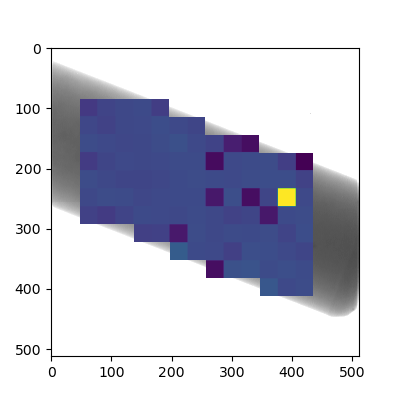

In [31]:
fig = plt.figure(figsize=(4,4), num='raw data')
ax = fig.add_subplot(111)
ax.imshow(integrated_image,
          vmin=0,
          vmax=1,
          cmap='gray')
ax.imshow(strain_mapping_2d)

# display data with interpolation (showing the issue) 

<IPython.core.display.Javascript object>


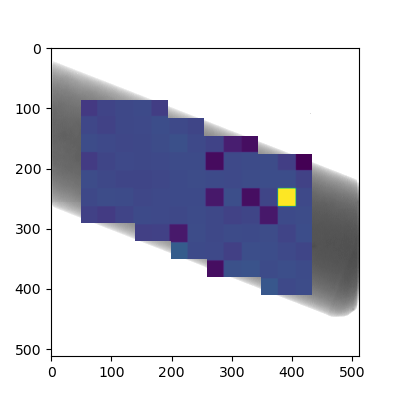

In [33]:
fig = plt.figure(num='not what we expected', figsize=(4,4))
ax = fig.add_subplot(111)
ax.imshow(integrated_image,
          vmin=0,
          vmax=1,
          cmap='gray')
ax.imshow(strain_mapping_2d, interpolation='gaussian')

<IPython.core.display.Javascript object>


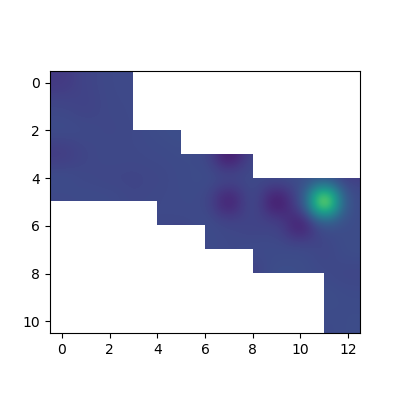

In [39]:
fig = plt.figure(num='works when strain_mapping data are not modified', figsize=(4,4))
ax = fig.add_subplot(111)
ax.imshow(strain_mapping_raw, interpolation='gaussian')

# Here are some of the things I tried so far 

## extract from matpltolib

Using matplotlib, I found a link that explained how to export the image and then increase its size to match the size of the image

Problem: because there are np.nan in the matrix, the export does not work

### original code 

<IPython.core.display.Javascript object>


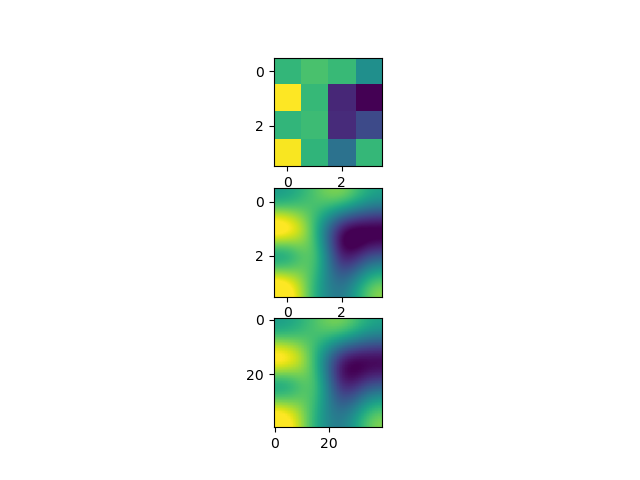

In [40]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.image import _resample
from matplotlib.transforms import Affine2D

np.random.seed(19680801)

grid = np.random.rand(4, 4)
scale_factor = 10
out_dimensions = (grid.shape[0]*scale_factor, grid.shape[1]*scale_factor)

fig, axs = plt.subplots(nrows=3)

transform = Affine2D().scale(scale_factor, scale_factor)
# Have to get an image to be able to resample
# Resample takes an _ImageBase or subclass, which require an Axes
img = axs[0].imshow(grid, interpolation='spline36', cmap='viridis')
interpolated = _resample(img, grid, out_dimensions, transform=transform)

axs[0].imshow(grid, cmap='viridis')
axs[1].imshow(grid, interpolation='spline36', cmap='viridis')
axs[2].imshow(interpolated, cmap='viridis')

but here is the result on my data

<IPython.core.display.Javascript object>


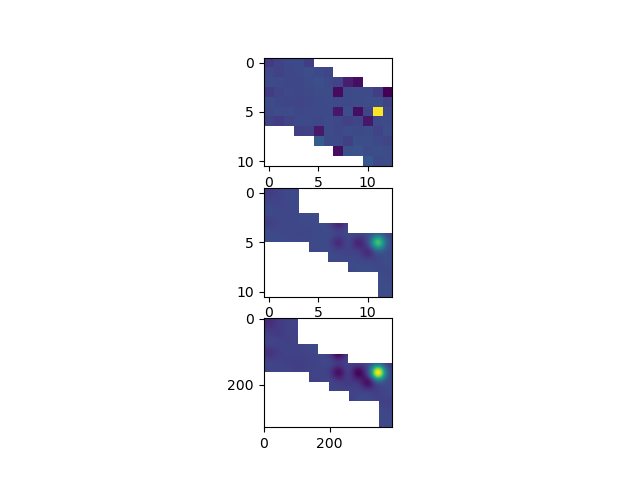

In [58]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.image import _resample
from matplotlib.transforms import Affine2D

data = strain_mapping_raw
grid = np.array(data)
index = np.isnan(grid)
# grid[index] = 0

scale_factor = bin_size
out_dimensions = (grid.shape[0]*scale_factor, grid.shape[1]*scale_factor)

fig, axs = plt.subplots(nrows=3)

transform = Affine2D().scale(scale_factor, scale_factor)
# Have to get an image to be able to resample
# Resample takes an _ImageBase or subclass, which require an Axes
# img = axs[0].imshow(grid, interpolation='spline36', cmap='viridis')
img = axs[0].imshow(grid, cmap='viridis')
axs[0].imshow(grid, cmap='viridis')

img1 = axs[1].imshow(grid, interpolation='gaussian', cmap='viridis')
interpolated = _resample(img1, grid, out_dimensions, transform=transform)

# axs[2].imshow(integrated_image, vmin=0, vmax=1, cmap='gray')
axs[2].imshow(interpolated, cmap='viridis')

# with overlap 

In [75]:
x0 = 47
y0 = 83

In [76]:
np.shape(interpolated)

(330, 390)

In [77]:
print(f"{inter_width =}")
print(f"{inter_height =}")

inter_width =390
inter_height =330


In [78]:
print(f"{x0 = }")
print(f"{y0 = }")
print(f"{bin_size = }")

x0 = 47
y0 = 83
bin_size = 30


In [79]:
print(np.shape(strain_mapping_2d[y0: y0+inter_height, x0: x0+inter_width]))

(330, 390)


In [80]:
strain_mapping_2d = np.empty((height, width))
strain_mapping_2d[:] = np.nan

inter_height, inter_width = np.shape(interpolated)

strain_mapping_2d[y0: y0+inter_height, x0: x0+inter_width] = interpolated


<IPython.core.display.Javascript object>


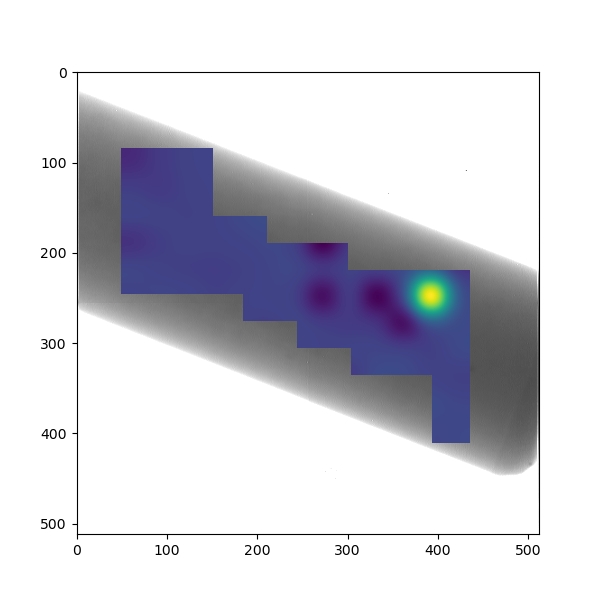

In [82]:
fig = plt.figure(num='interpolation and overlaop', figsize=(6, 6))
ax = fig.add_subplot(111)
ax.imshow(integrated_image,
          vmin=0,
          vmax=1,
          cmap='gray')
ax.imshow(strain_mapping_2d, interpolation='gaussian')